In [2]:
include("PVCR.jl");

In [3]:
ICE_CB= CSV.read("data/ICE_CB.csv");
using Query
PyPlot.svg(true)

true

# Current Tariff System

# Impact of residential Consumers adopting rooftop PV systems.

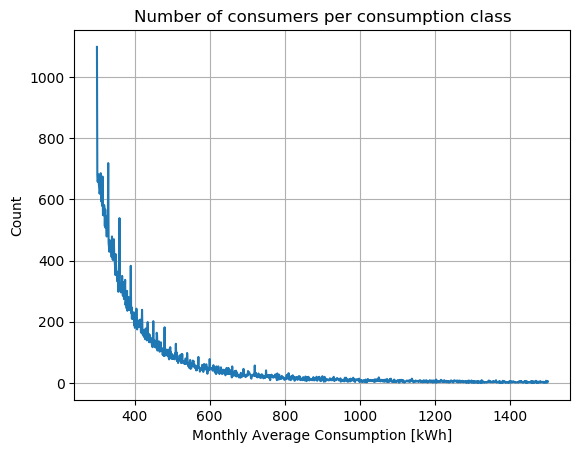

In [4]:
ICE_res = @from i in ICE_CB begin 
    @where (i.Consumo >= 300 && i.Consumo <= 1500)
    @select {i.Consumo, i.TRE} 
    @collect DataFrame
    end;
plot(ICE_res[:Consumo], ICE_res[:TRE]);
title("Number of consumers per consumption class")
xlabel("Monthly Average Consumption [kWh]")
ylabel("Count")
grid("on");

## Baseline Calculations - Residential

In [5]:
ui_res = []
ui_data_res = Dict{Int64,Any}()
for i in 1:size(ICE_res,1)
    Result = Dict{String,Any}()
    ice_residential.econsumption = ICE_res[:Consumo][i]; get_pmax(ice_residential);
    PVRes_opt = deepcopy(PVRes)
    PVRes_opt.capacity = 0.0
    Result["Revenue"] = utility_revenue(ice_residential, PVRes_opt, SD)*ICE_res[:TRE][i];
    ui_data_res[ICE_res[:Consumo][i]] = Result  
end

In [6]:
cumulative_revenue_res = [(sum(ui_data_res[i]["Revenue"]; dims = 1)*discount_factor)./1e6 for i in ICE_res[:Consumo]];
println("NPV of revenue Over 10 years", " ", sum(cumulative_revenue_res), " Million Colones")

NPV of revenue Over 10 years [1.89462e6] Million Colones


In [7]:
ui_res = []
ui_data_res = Dict{Int64,Any}()

for i in 1:size(ICE_res,1)
    Result = Dict{String,Any}()
    ice_residential.econsumption = ICE_res[:Consumo][i]; get_pmax(ice_residential);
    res = optimal_pv(ice_residential, PVRes, 0.0:0.5:15, BAC1, tariff_increase = true)
    res[1][2] < 0.5 ? break : true 
    PVRes_opt = deepcopy(PVRes) 
    PVRes_opt.capacity = res[1][2]
    Result["optimal"] = res[1][2]
    Result["Impact"] = PV_losses(ice_residential, PVRes_opt, SD)*ICE_res[:TRE][i];
    ui_data_res[ICE_res[:Consumo][i]] = Result  
end

In [8]:
cumulative_impact_res = [(sum(ui_data_res[i]["Impact"]; dims = 1)*discount_factor)./1e6 for i in ICE_res[:Consumo]];
println("Total Losses Over 10 years", " ", sum(cumulative_impact_res), " Million Colones")

Total Losses Over 10 years [-1.54521e6] Million Colones


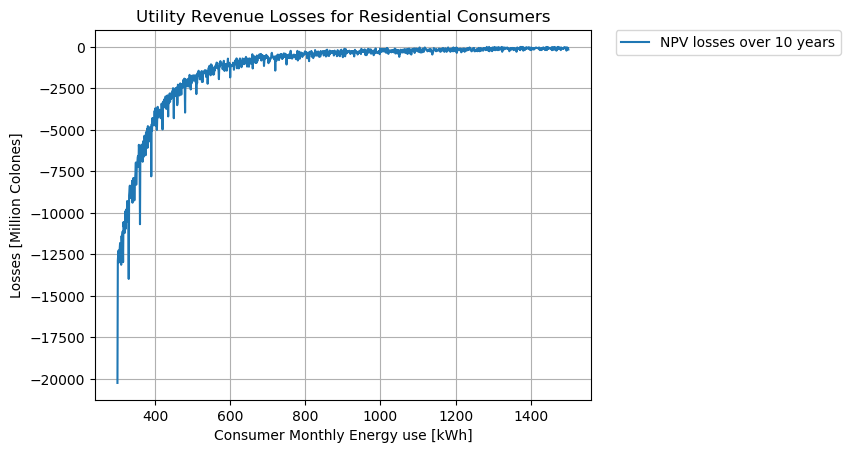

In [9]:
plot(ICE_res[:Consumo], cumulative_impact_res, label = "NPV losses over 10 years")
legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
ylabel("Losses [Million Colones]")
xlabel("Consumer Monthly Energy use [kWh]")
title("Utility Revenue Losses for Residential Consumers")
grid("on");

# Impact From Commercial - Industrial Consumers adopting optimal Rooftop PV

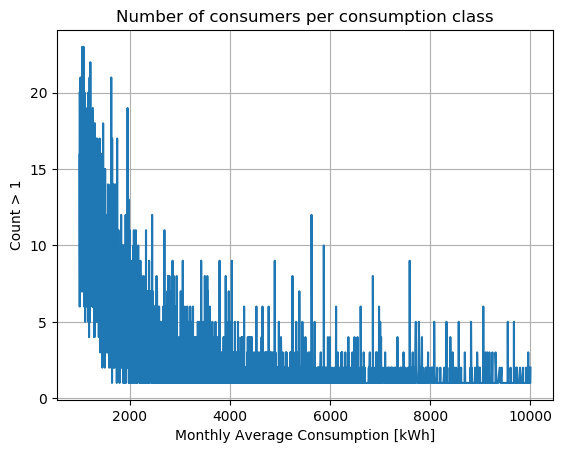

In [4]:
ICE_gen = @from i in ICE_CB begin 
    @where (i.Consumo >= 1000 && i.Consumo <= 10000)
    @select {i.Consumo, i.TCO, i.TIN} 
    @collect DataFrame
end
ICE_gen[:TGEN] = ICE_gen[:TCO] + ICE_gen[:TIN];
ICE_gen = ICE_gen[ICE_gen.TGEN .> 0, :]
plot(ICE_gen[:Consumo], ICE_gen[:TGEN]);
title("Number of consumers per consumption class")
xlabel("Monthly Average Consumption [kWh]")
ylabel("Count > 1");
grid("on");

## Baseline Calculations - Commercial Industrial

In [11]:
ui_comind = []
bl_ui_data_comind = Dict{Int64,Any}()
for i in 1:size(ICE_gen,1)
    Result = Dict{String,Any}()
    ice_commercial.econsumption = ICE_gen[:Consumo][i]; get_pmax(ice_commercial);
    PVComInd_opt = deepcopy(PVComInd) 
    PVComInd_opt.capacity = 0.0
    Result["Revenue"] = utility_revenue(ice_commercial, PVComInd_opt, SD)*ICE_gen[:TGEN][i];
    bl_ui_data_comind[i] = Result  
end

In [12]:
cumulative_revenue_commind = [(sum(bl_ui_data_comind[i]["Revenue"]; dims = 1)*discount_factor)./1e6 for i in 1:size(ICE_gen[:Consumo],1)];
println("NPV of revenue Over 10 years", " ", sum(cumulative_revenue_commind), " Million Colones")

NPV of revenue Over 10 years [5.62902e5] Million Colones


In [ ]:
ui_comind = []
ui_data_comind = Dict{Int64,Any}()
for i in 1:size(ICE_gen,1)
    Result = Dict{String,Any}()
    ice_commercial.econsumption = ICE_gen[:Consumo][i]; get_pmax(ice_commercial);
    res = optimal_pv(ice_commercial, PVComInd, 0.0:1:100, BAC1, tariff_increase = true)
    res[1][2] < 0.5 ? continue : true 
    PVComInd_opt = deepcopy(PVComInd) 
    PVComInd_opt.capacity = res[1][2]
    Result["optimal"] = res[1][2]
    Result["Impact"] = PV_losses(ice_commercial, PVComInd_opt, SD)*ICE_gen[:TGEN][i];
    ui_data_comind[i] = Result  
end

In [ ]:
cumulative_impact_comind = [(sum(ui_data_comind[i]["Impact"]; dims = 1)*discount_factor)./1e6 for i in 1:size(ICE_gen,1)];
println("Total Losses Over 10 years", " ", sum(cumulative_impact_comind), " Million Colones")

In [ ]:
plot(ICE_gen[:Consumo], cumulative_impact_comind, label = "NPV losses over 10 years")
legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
ylabel("Losses [Million Colones]")
xlabel("Consumer Monthly Energy use [kWh]")
title("Utility Revenue Losses for Commercial Consumers")
grid("on");

# Impact of Medium Voltage Consumers adopting rooftop PV systems. 

In [ ]:
ICE_TMT = @from i in ICE_CB begin 
    @where (i.Consumo >= 10000 && i.TMT > 0)
    @select {i.Consumo, i.TMT} 
    @collect DataFrame
    end;
ICE_TMT = ICE_TMT[ICE_TMT.TMT .> 0, :]
b= hist(ICE_TMT[ICE_TMT.Consumo .< 500000, :Consumo], bins = 100);
title("Histogram consumers per consumption class")
xlabel("Monthly Average Consumption [kWh]")
ylabel("Count of consumers")

## Baseline Calculations - TMT

In [ ]:
ui_tmt = []
ui_data_tmt = Dict{Int64,Any}()
for i in 1:size(ICE_TMT,1)
    Result = Dict{String,Any}()
    ice_mediumvoltage.econsumption = ICE_TMT[:Consumo][i]; get_pmax(ice_mediumvoltage);
    PVTMT_opt = deepcopy(PVTMT) 
    PVTMT_opt.capacity = 0.0
    Result["Revenue"] = utility_revenue(ice_mediumvoltage, PVTMT_opt, SD)*ICE_TMT[:TMT][i];
    ui_data_tmt[i] = Result  
end

In [ ]:
cumulative_revenue_tmt = [(sum(ui_data_tmt[i]["Revenue"]; dims = 1)*discount_factor)./1e6 for i in size(ICE_TMT,1)];
println("NPV of revenue Over 10 years", " ", sum(cumulative_revenue_tmt), " Million Colones")

In [ ]:
ui_tmt = []
ui_data_tmt = Dict{Int64,Any}()
for i in 1:size(ICE_TMT,1)
    Result = Dict{String,Any}()
    ice_mediumvoltage.econsumption = ICE_TMT[:Consumo][i]; get_pmax(ice_mediumvoltage);
    res = optimal_pv(ice_mediumvoltage, PVTMT, 0.0:1:400, BAC1, tariff_increase = true)
    res[1][2] < 0.5 ? continue : true 
    PVTMT_opt = deepcopy(PVTMT) 
    PVTMT_opt.capacity = res[1][2]
    Result["optimal"] = res[1][2]
    Result["Impact"] = PV_losses(ice_mediumvoltage, PVTMT_opt, SD)*ICE_TMT[:TMT][i];
    ui_data_tmt[i] = Result  
end

In [ ]:
cumulative_impact_tmt = [(sum(ui_data_tmt[i]["Impact"]; dims = 1)*discount_factor)./1e6 for i in 1:size(ICE_TMT,1)];
println("Total Losses Over 10 years", " ", sum(cumulative_impact_tmt), " Million Colones")

In [ ]:
plot(ICE_TMT[:Consumo]./1e3, cumulative_impact_tmt, label = "NPV losses over 10 years")
legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
ylabel("Losses [Million Colones]")
xlabel("Consumer Monthly Energy use [x1000 kWh]")
title("Utility Revenue Losses for Medium Voltage Consumers")
grid("on");

# New Tariff System

# Impact From Commercial - Industrial Consumers adopting optimal Rooftop PV

In [ ]:
ice_commercial.tariff = A_CI_ICE
ui_comind = []
bl_ui_data_comind = Dict{Int64,Any}()
for i in 1:size(ICE_gen,1)
    Result = Dict{String,Any}()
    ice_commercial.econsumption = ICE_gen[:Consumo][i]; get_pmax(ice_commercial);
    PVRes_opt = deepcopy(PVRes)
    PVComInd_opt = deepcopy(PVComInd) 
    PVComInd_opt.capacity = 0.0
    Result["Revenue"] = utility_revenue(ice_commercial, PVComInd_opt, SD)*ICE_gen[:TGEN][i];
    bl_ui_data_comind[i] = Result  
end

In [ ]:
cumulative_revenue_commind = [(sum(bl_ui_data_comind[i]["Revenue"]; dims = 1)*discount_factor)./1e6 for i in 1:size(ICE_gen[:Consumo],1)];
println("NPV of revenue Over 10 years", " ", sum(cumulative_revenue_commind), " Million Colones")

In [ ]:
ice_commercial.tariff = A_CI_ICE
alt_ui_comind = []
alt_ui_data_comind = Dict{Int64,Any}()
for i in 1:size(ICE_gen,1)
    Result = Dict{String,Any}()
    ice_commercial.econsumption = ICE_gen[:Consumo][i]; get_pmax(ice_commercial);
    res = optimal_pv(ice_commercial, PVComInd, 0.0:1:100, BAC1, tariff_increase = true)
    res[1][2] < 0.5 ? continue : true 
    PVComInd_opt = deepcopy(PVComInd) 
    PVComInd_opt.capacity = res[1][2]
    Result["optimal"] = res[1][2]
    Result["Impact"] = PV_losses(ice_commercial, PVComInd_opt, SD)*ICE_gen[:TGEN][i];
    alt_ui_data_comind[i] = Result  
end

In [ ]:
alt_cumulative_impact_comind = [(sum(alt_ui_data_comind[i]["Impact"]; dims = 1)*discount_factor)./1e6 for i in 1:size(ICE_gen,1)];
println("Total Losses Over 10 years", " ", sum(alt_cumulative_impact_comind), " Million Colones")

In [ ]:
plot(ICE_gen[:Consumo], alt_cumulative_impact_comind, label = "NPV losses over 10 years")
legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
ylabel("Losses [Million Colones]")
xlabel("Consumer Monthly Energy use [kWh]")
title("Utility Revenue Losses for Commercial Consumers - Alternative Tariff System")
grid("on");

# Impact of Medium Voltage Consumers adopting rooftop PV systems. 

In [ ]:
ice_mediumvoltage.tariff = A_TMT_ICE
ui_tmt = []
ui_data_tmt = Dict{Int64,Any}()
for i in 1:size(ICE_TMT,1)
    Result = Dict{String,Any}()
    ice_mediumvoltage.econsumption = ICE_TMT[:Consumo][i]; get_pmax(ice_mediumvoltage);
    PVTMT_opt = deepcopy(PVTMT) 
    PVTMT_opt.capacity = 0.0
    Result["Revenue"] = utility_revenue(ice_mediumvoltage, PVTMT_opt, SD)*ICE_TMT[:TMT][i];
    ui_data_tmt[i] = Result  
end

In [ ]:
cumulative_revenue_tmt = [(sum(ui_data_tmt[i]["Revenue"]; dims = 1)*discount_factor)./1e6 for i in size(ICE_TMT[:Consumo],1)];
println("NPV of revenue Over 10 years", " ", sum(cumulative_revenue_tmt), " Million Colones")

In [ ]:
ice_mediumvoltage.tariff = A_TMT_ICE
alt_ui_tmt = []
alt_ui_data_tmt = Dict{Int64,Any}()
for i in 1:size(ICE_TMT,1)
    Result = Dict{String,Any}()
    ice_mediumvoltage.econsumption = ICE_TMT[:Consumo][i]; get_pmax(ice_mediumvoltage);
    res = optimal_pv(ice_mediumvoltage, PVTMT, 0.0:1:400, BAC1, tariff_increase = true)
    res[1][2] < 0.5 ? continue : true 
    PVTMT_opt = deepcopy(PVTMT) 
    PVTMT_opt.capacity = res[1][2]
    Result["optimal"] = res[1][2]
    Result["Impact"] = PV_losses(ice_mediumvoltage, PVTMT_opt, SD)*ICE_TMT[:TMT][i];
    alt_ui_data_tmt[i] = Result  
end

In [ ]:
alt_cumulative_impact_tmt = [(sum(alt_ui_data_tmt[i]["Impact"]; dims = 1)*discount_factor)./1e6 for i in 1:size(ICE_TMT,1)]; 
println("Total Losses Over 10 years", " ", sum(alt_cumulative_impact_tmt), " Million Colones")

In [ ]:
plot(ICE_TMT[:Consumo]./1e3, alt_cumulative_impact_tmt, label = "NPV losses over 10 years")
legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
ylabel("Losses [Million Colones]")
xlabel("Consumer Monthly Energy use [x1000 kWh]")
title("Utility Revenue Losses for Medium Voltage Consumers - Alternative Tariff System")
grid("on");